In [1]:
import pathlib
import numpy as np
from numpy import argmax
import h5py
import time

import pandas as pd
#import dask.dataframe as dd

import tensorflow as tf
from tensorflow import keras

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score,f1_score,precision_score,recall_score 
from sklearn.metrics import confusion_matrix

import collections
#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots

In [2]:
# Create a dataset.
family_label = './raw_data/GSE90496_methylation_family_label.csv'

def load_csv(filepath):
    data =  []
    col = []
    checkcol = False
    with open(filepath) as f:
        for val in f.readlines():
            val = val.replace("\n","")
            val = val.split(',')
            if checkcol is False:
                col = val
                checkcol = True
            else:
                data.append(val)
    df = pd.DataFrame(data=data, columns=col)
    return df

def process_csv(filename):
    df = pd.read_csv(filename, index_col=0)
    y = df.y
    X = df.drop(columns=['y'])
    return (X, y)

def get_beta_in_select_file(beta, filename):
    X_temp, y = process_csv(filename)
    X = beta[ X_temp.index ]
    y = pd.DataFrame(y)
    return X.T, y

def get_x_y_data(filename, num_probe_return=False):
    df = pd.read_csv(filename, header=0, index_col=0)
    probe_data_t = np.array(df)
    num_probes = len(df.columns)-1
    X = probe_data_t[0:, 0:num_probes]
    y = df['y']
    if (num_probe_return == False):
        return X,y
    else:
        return X, y, num_probes
    
def get_oneHotCode_matrix(labels, encoder):
    integer_encoded = encoder.fit_transform(labels)
    num_classes = len(np.unique(labels))
    labels_one_hot = keras.utils.to_categorical(integer_encoded, num_classes)
    return labels_one_hot


In [3]:
def select_probes(data, sd_cutoff):
    probes = data.T
    probes['STD'] = probes.std(axis=1)
    above_threshold = probes[probes["STD"] > sd_cutoff]
    print("shape in select_probes", above_threshold.shape)
    return above_threshold.drop(columns='STD').T

def match_probes(ref_data, data_to_be_matched):
    df = data_to_be_matched.loc[:, ref_data.columns.values]
    return df

In [18]:

def create_model(n_inputs,n_classes):
    model = keras.Sequential()

    model.add(keras.layers.Dense(1000, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(keras.layers.Dense(n_classes, activation="softmax"))
    
    model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', 
                  metrics=['accuracy', 'Precision','Recall', 'mae', 'mse'])
    
    return model


def cross_validate(model, data_x, data_y, cv, encoder, cls_weight):
    '''
    features were selected before running CV
    '''
    cvscores = []
    fold = 1
    
    for train_index,test_index in cv.split(data_x, data_y):
        x_train = np.asarray(data_x[train_index]).astype(np.float32) ###convert to np.float32 to be used in model.fit
        x_test = np.asarray(data_x[test_index]).astype(np.float32)
        
        y_train,y_test=data_y[train_index],data_y[test_index]
        y_train_encode = get_oneHotCode_matrix(y_train, encoder)
        y_test_encode = get_oneHotCode_matrix(y_test, encoder)
        
        val_sample_weights = class_weight.compute_sample_weight(cls_weight_dict, y_test_encode)
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold} ...')
        model.fit(x_train, y_train_encode,epochs=20, class_weight=cls_weight, batch_size=50, verbose=0)
        
        scores = model.evaluate(x_test, y_test_encode, sample_weight = val_sample_weights, verbose=0)
        cvscores.append(scores)
        fold = fold+1
        #print(list(zip(model.metrics_names, np.round(scores,2))))
        
    return pd.DataFrame(cvscores, columns= model.metrics_names)

def evaluate_against_test_set(mod, x_test, y_test, encoder, cls_weight):
    y_pred = get_pred_label(mod, x_test, y_test, encoder)
    y_test_encode = encoder.fit_transform(y_test)
    test_sample_weights = class_weight.compute_sample_weight(cls_weight, y_test_encode)
    acc=accuracy_score(y_test,y_pred).round(3)
    bal_acc=balanced_accuracy_score(y_test,y_pred, sample_weight = test_sample_weights).round(3)
    rec=recall_score(y_test,y_pred, average='weighted', zero_division=0).round(3)
    prec=precision_score(y_test,y_pred, average='weighted', zero_division=0).round(3)
    f1=f1_score(y_test,y_pred, average='weighted').round(3)
    return (acc, bal_acc, rec, prec, f1)

def cross_validate2(data_x, data_y, cv, encoder, cls_weight, sd_cutoff):
    '''
    features are selectiving for the training data set after each CV split
    '''
    #cvscores = []
    cv_balanced_scores = []
    fold = 1
    for train_index,test_index in cv.split(data_x, data_y):
        #print("X_cv shape = ", data_x.shape, "; y_cv shape = ", data_y.shape)
        x_train_temp = select_probes(data_x.iloc[train_index, :], sd_cutoff)
        x_test_temp = match_probes(x_train_temp, data_x.iloc[test_index, :])
        x_train = np.asarray(x_train_temp).astype(np.float32) ###convert to np.float32 to be used in model.fit
        x_test = np.asarray(x_test_temp).astype(np.float32)
        y_train,y_test = data_y.iloc[train_index, :], data_y.iloc[test_index, :]
        y_train_encode = get_oneHotCode_matrix(y_train.values.ravel(), encoder)
        y_test_encode = get_oneHotCode_matrix(y_test.values.ravel(), encoder)
        
        n_inputs = len(x_train_temp.columns)
        #model1 = create_model(n_inputs, len(np.unique(y_test))) 
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold} ...')
        #model1.fit(x_train, y_train_encode,epochs=20, batch_size=50, verbose=0)
        #scores = model1.evaluate(x_test, y_test_encode, verbose=0)
        #cvscores.append(scores)
        
        model2 = create_model(n_inputs, len(np.unique(y_test))) 
        y_test_intcode = encoder.fit_transform(y_test.values.ravel())
        val_sample_weights = class_weight.compute_sample_weight(cls_weight, y_test_intcode)
        model2.fit(x_train, y_train_encode,epochs=20, cls_weight = cls_weight, batch_size=50, verbose=0)
        scores2 = model2.evaluate(x_test, y_test_encode, sample_weight=val_sample_weights, verbose=0)
        cv_balanced_scores.append(scores2)
        
        fold = fold+1
    return model2, x_train_temp,  pd.DataFrame(cv_balanced_scores, columns= model2.metrics_names)

def get_pred_label2(mod, feature, x, y, encoder):
    x_test_temp = match_probes(feature, x)
    Xtest = np.asarray(x_test_temp).astype(np.float32)
    pred_scores = mod.predict(Xtest)
    pred_int_code = np.argmax(pred_scores, axis=1)
    y_pred = encoder.inverse_transform(pred_int_code)
    return y_pred

def accuracy_per_class(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    per_class_accuracies = cm.diagonal()/cm.sum(axis=1)
    per_class_acc_wKeys = {}
    for idx, cls in enumerate(classes):
        per_class_acc_wKeys[cls] = per_class_accuracies[idx]
    return per_class_acc_wKeys


def create_per_class_acc_df(class_acc, seed, dataset_name):
    d = pd.DataFrame(columns = ['Seed', 'Dataset'])
    d = d.append(class_acc, ignore_index=True)
    d['Seed'] = seed
    d['Dataset'] = dataset_name
    return d

def evaluate_against_test_set2(mod, feature, x_test, y_test, encoder, cls_weight):
    y_pred = get_pred_label2(mod, feature, x_test, y_test, encoder)
    y_test_encode = encoder.fit_transform(y_test.values.ravel())
    test_sample_weights = class_weight.compute_sample_weight(cls_weight, y_test_encode)
    
    acc=accuracy_score(y_test,y_pred).round(3)
    bal_acc=balanced_accuracy_score(y_test,y_pred).round(3)
    rec=recall_score(y_test,y_pred, average='weighted', sample_weight=test_sample_weights, zero_division=0).round(3)
    prec=precision_score(y_test,y_pred, average='weighted', zero_division=0).round(3)
    f1=f1_score(y_test,y_pred, average='weighted').round(3)
    per_class_acc = accuracy_per_class(y_test, y_pred)
    
    return (acc, bal_acc, rec, prec, f1, per_class_acc)

In [12]:
####functions to gather results

def append_result(p, df):
    s = pd.Series(p, index=df.columns)
    return df.append(s, ignore_index=True)

def append_testset_results(df, r, seed_name, dataset_name):
    df = append_result([seed_name, dataset_name, 'vs_testset', 'accuracy', r[0]], df)
    df = append_result([seed_name, dataset_name, 'vs_testset', 'balanced_acc', r[1]], df)
    df = append_result([seed_name, dataset_name, 'vs_testset', 'recall_weighted', r[2]], df)
    df = append_result([seed_name, dataset_name, 'vs_testset', 'precision_weighted', r[3]], df)
    df = append_result([seed_name, dataset_name, 'vs_testset', 'f1_weighted', r[4]], df)
    return df

def apply_CV(mod, cv, X, y):
    return cross_validate(mod, X, y, cv=cv, scoring=['balanced_accuracy', 'accuracy', 'recall_weighted'])

def append_cv_results(df, r, seed_name, dataset_name, typeVal_name):
    df = append_result([seed_name, dataset_name, typeVal_name, 'loss', r['loss'].mean()], df)
    df = append_result([seed_name, dataset_name, typeVal_name, 'accuracy', r['accuracy'].mean()], df)
    df = append_result([seed_name, dataset_name, typeVal_name, 'precision', r['precision'].mean()], df)
    df = append_result([seed_name, dataset_name, typeVal_name, 'recall', r['recall'].mean()], df)
    df = append_result([seed_name, dataset_name, typeVal_name, 'mae', r['mae'].mean()], df)
    df = append_result([seed_name, dataset_name, typeVal_name, 'mse', r['mse'].mean()], df)

    return df



In [15]:
def evaluate(seed, rkfold, encoder, cls_weight, sd_cutoff=0.3):
    print('1. Read files (seed={})'.format(seed))
       
    file35 = './data_family/seed{}_35perc.csv'.format(seed)
    file70='./data_family/seed{}_70percLC.csv'.format(seed)
    file70HC= './data_family/seed{}_70percHC.csv'.format(seed)
    
    fileHoldOut = './data_family/seed{}_holdOutTest.csv'.format(seed)
    
    #########
    print('\tReading', file35)
    X35, y35 = get_beta_in_select_file(beta,file35)
    print('\tReading', file70)
    X70, y70 = get_beta_in_select_file(beta,file70)
    print('\tReading', file70HC)
    X70HC, y70HC = get_beta_in_select_file(beta, file70HC)
           
    print('\tReading', fileHoldOut)
    xitest, yitest = get_beta_in_select_file(beta, fileHoldOut)
    ###################
    
    print('2. Evaluate model with 35% data')
    nnmodel35, features35, result_cv_35 = cross_validate2(X35, y35, rkfold, encoder, cls_weight, sd_cutoff=sd_cutoff)
    print('\tvalidate against test set')
    result_ts_35 = evaluate_against_test_set2(nnmodel35, features35, xitest, yitest, encoder, cls_weight)
          
    print('3. Evaluate model with 70% data')
    nnmodel70, features70, result_cv_70 = cross_validate2(X70, y70, rkfold, encoder, cls_weight, sd_cutoff=sd_cutoff)
    print('\tvalidate against test set')
    result_ts_70 = evaluate_against_test_set2(nnmodel70, features70, xitest, yitest, encoder, cls_weight)

    print('4. Evaluate model with 70% HC')    
    nnmodel70HC, features70HC, result_cv_70HC = cross_validate2(X70HC, y70HC, rkfold, encoder, cls_weight, sd_cutoff=sd_cutoff)
    print('\tvalidate against test set')
    result_ts_70HC = evaluate_against_test_set2(nnmodel70HC, features70HC, xitest, yitest, encoder, cls_weight)
    
    #########
    
    print('6. Store results.')
    df = pd.DataFrame(data=[], columns=['Seed','Dataset','Validation','Metric','Value'])
    df = append_cv_results(df, result_cv_35, seed, '35', 'cross_val')
    #df = append_cv_results(df, result_cv_35[1], seed, '35', 'balanced_cross_val')
    
    df = append_testset_results(df, result_ts_35, seed, '35')
    
    df = append_cv_results(df, result_cv_35, seed, '70', 'cross_val')
    #df = append_cv_results(df, result_cv_35[1], seed, '70', 'balanced_cross_val')
    df = append_testset_results(df, result_ts_70, seed, '70')
    
    df = append_cv_results(df, result_cv_35, seed, '70HC', 'cross_val')
    #df = append_cv_results(df, result_cv_35[1], seed, '70HC', 'balanced_cross_val')
    df = append_testset_results(df, result_ts_70HC, seed, '70HC')
    
    df_class_acc = pd.DataFrame(columns = ['Seed', 'Dataset'])
    
    df_class = create_per_class_acc_df(result_ts_35[5], seed, '35')
    df_class = df_class.append(create_per_class_acc_df(result_ts_70[5], seed, '70'))
    df_class = df_class.append(create_per_class_acc_df(result_ts_70HC[5], seed, '70HC'))
       
    return (df, df_class)



In [68]:
def run_one_seed(probe_data, labels, n_split, n_repeat, random_state, seed):

    ###use 70% for training and 30% for indepent testing
    X_cv, X_test, y_cv, y_test = train_test_split(probe_data, labels, test_size=0.3, random_state=random_state)
    
    ####create model with CV
    rkfold = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=random_state)   
    
    result = cross_validate2(model, X_cv, y_cv, rkfold, label_encoder, cls_weight_dict, sd_cutoff=0.3)
    print(result.mean())
    print(result)
    ####

    ###evaluate on the test set
    '''
    X_test, y_test = get_x_y_data(fileHoldOut)
    test_result = evaluate_against_test_set(model, X_test, y_test, label_encoder, cls_weight_dict)
    print("test result", test_result)
    
    y_test_pred = get_pred_label(model, X_test, y_test, label_encoder)
    per_class_acc = accuracy_per_class(y_test, y_test_pred)
    df_per_class_acc = create_per_class_acc_df(per_class_acc, seed=seed, dataset_name='35perc')
    print(df_per_class_acc)
    '''
    
def run_one_seed2(probe_data, labels, n_split, n_repeat, random_state, seed):

   
    ####create model with CV
    rkfold = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=random_state)   
    
    result = cross_validate2(model, X_cv, y_cv, rkfold, label_encoder, cls_weight_dict, sd_cutoff=0.3)
    print(result.mean())
    print(result)
    ####

    ###evaluate on the test set
    
    test_result = evaluate_against_test_set(model, X_test, y_test, label_encoder, cls_weight_dict)
    print("test result", test_result)
    
    y_test_pred = get_pred_label(model, X_test, y_test, label_encoder)
    per_class_acc = accuracy_per_class(y_test, y_test_pred)
    df_per_class_acc = create_per_class_acc_df(per_class_acc, seed=seed, dataset_name='35perc')
    print(df_per_class_acc)
    return df_per_class_acc
    

## Computer class weights

In [5]:
family_label = './raw_data/GSE90496_methylation_family_label.csv'
#family_label = '/research/rgs01/home/clusterHome/qtran/Semisupervised_Learning/python/raw_data/GSE90496_methylation_family_label.csv'

y = pd.read_csv(family_label, header=0, names=['labels'])
###create a labelencoder to transform str classes to integer classes 
###and use the labelencoder to reverse transform to get the str labels throughout
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y['labels'])
###
    
###calculate class weights to let the model to pay attention to the under-represented classes
cls_weights = class_weight.compute_class_weight("balanced", classes=np.unique(integer_encoded), y=integer_encoded)
cls_weight_dict = {}
for cls in np.unique(integer_encoded):
    cls_weight_dict[cls] = cls_weights[cls].round(3)



## Read the original beta values for 2801 reference samples

In [8]:
tic = time.process_time()
beta_file = './raw_data/top32K_GSE90496.txt'
beta = pd.read_csv(beta_file, index_col=0)
#beta.drop(beta.filter(regex="Unnamed"),axis=1, inplace=True)

toc = time.process_time()

'''
tic = time.process_time()
beta_file = '/research/rgs01/home/clusterHome/qtran/Semisupervised_Learning/python/raw_data/GSE90496_beta_cgkeep.csv'
beta = load_csv(beta_file)
toc = time.process_time()
'''
toc-tic
    

15.377439

In [9]:
beta.iloc[1:10, 1:10]

,GSM2402863_5684819013_R04C01,GSM2402953_6164621144_R03C02,GSM2403853_9305651003_R06C02,GSM2403854_9305651005_R03C02,GSM2403855_9305651013_R06C01,GSM2403856_9305651003_R02C01,GSM2403857_9305651005_R04C02,GSM2403858_9305651016_R04C01,GSM2403859_9305651003_R03C01
cg16476975,0.012228,0.771968,0.827790,0.143162,0.958136,0.095097,0.969612,0.381747,0.632224
cg03940848,0.491114,0.827459,0.407930,0.047350,0.050784,0.045952,0.053040,0.053028,0.429148
cg01517680,0.855149,0.888793,0.945822,0.728753,0.953829,0.953940,0.952785,0.073702,0.783889
cg11536474,0.804166,0.651743,0.944315,0.049581,0.328500,0.899993,0.063354,0.877387,0.898767
cg02809746,0.716434,0.779486,0.079752,0.071122,0.046674,0.039802,0.082190,0.037412,0.210761
cg05649108,0.782951,0.702369,0.913383,0.073262,0.065488,0.071702,0.046682,0.081744,0.206060
cg24375409,0.751254,0.841802,0.062306,0.038255,0.040862,0.031619,0.059486,0.042882,0.259511
cg00295794,0.795606,0.496170,0.946636,0.040310,0.050893,0.943775,0.065446,0.898026,0.777311
cg17129986,0.711197,0.881524,0.902108,0.953402,0.944339,0.872516,0.964101,0.117637,0.947552


In [10]:
seed = 1
file35 = './data_family/seed{}_35perc.csv'.format(seed)    
file70 = './data_family/seed{}_70percLC.csv'.format(seed)
fileHoldOut = './data_family/seed{}_holdOutTest.csv'.format(seed)


print('\tReading', file35)
X35, y35 = get_beta_in_select_file(beta, file35)

print('\tReading', file70)
X70, y70 = get_beta_in_select_file(beta, file70)

print('\tReading', fileHoldOut)
xitest, yitest = get_beta_in_select_file(beta, fileHoldOut)




	Reading ./data_family/seed1_35perc.csv
	Reading ./data_family/seed1_70percLC.csv
	Reading ./data_family/seed1_holdOutTest.csv


Select all the rows of beta with columns that are index of X35.

In [40]:
rand = 123456
rkfold = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=rand)
for seed in [1, 2, 20]:
    result = evaluate(seed=seed, rkfold = rkfold, encoder=label_encoder, cls_weight = cls_weight_dict, sd_cutoff=0.3)
    output_file = 'result_family_seed{}_{}.csv'.format(seed, rand)
    output_per_family_file = './output_acc_perFamily/result_acc_perFamily_seed{}_{}.csv'.format(seed, rand)
    result[0].to_csv(output_file, index=False)
    result[1].to_csv(output_per_family_file, index=False)
    print('Result saved to', output_file)

1. Read files (seed=1)
	Reading ./data_family/seed1_35perc.csv
	Reading ./data_family/seed1_70perc.csv
	Reading ./data_family/seed1_70percHC.csv
	Reading ./data_family/seed1_holdOutTest.csv
2. Evaluate model with 35% data
shape in select_probes (4296, 487)
------------------------------------------------------------------------
Training for fold 1 ...
shape in select_probes (3695, 488)
------------------------------------------------------------------------
Training for fold 2 ...
	validate against test set
3. Evaluate model with 70% data
shape in select_probes (3826, 980)
------------------------------------------------------------------------
Training for fold 1 ...
shape in select_probes (4357, 981)
------------------------------------------------------------------------
Training for fold 2 ...
	validate against test set
4. Evaluate model with 70% HC
shape in select_probes (4184, 912)
------------------------------------------------------------------------
Training for fold 1 ...
sh

KeyError: 2

In [22]:
nnmodel, features, result = cross_validate2(X35, y35, rkfold, label_encoder, cls_weight_dict, sd_cutoff=0.3)
print(result.mean())
print(result)    

shape in select_probes (4260, 487)
------------------------------------------------------------------------
Training for fold 1 ...
shape in select_probes (3740, 488)
------------------------------------------------------------------------
Training for fold 2 ...
loss         0.139009
accuracy     0.962999
precision    0.982887
recall       0.941421
mae          0.002312
mse          0.000789
dtype: float64
       loss  accuracy  precision    recall       mae       mse
0  0.139815  0.965092   0.989177  0.938398  0.002487  0.000751
1  0.138204  0.960905   0.976596  0.944444  0.002137  0.000826


In [26]:
y_pred = get_pred_label2(nnmodel, features, xitest, yitest, label_encoder)
y_test_encode = label_encoder.fit_transform(yitest.values.ravel())
test_sample_weights = class_weight.compute_sample_weight(cls_weight_dict, y_test_encode)

In [27]:
acc=accuracy_score(yitest.values.ravel(),y_pred).round(3)
bal_acc=balanced_accuracy_score(yitest,y_pred, sample_weight = test_sample_weights).round(3)
rec=recall_score(yitest,y_pred, average='weighted', zero_division=0).round(3)
prec=precision_score(yitest,y_pred, average='weighted', zero_division=0).round(3)
f1=f1_score(yitest,y_pred, average='weighted').round(3)
per_class_acc = accuracy_per_class(yitest, y_pred)

In [137]:
df_class = create_per_class_acc_df(per_class_acc, seed, '35')

In [138]:
df_class

,Seed,Dataset,ANA PA,CHGL,CHORDM,CN,"CNS NB, FOXR2","CONTR, ADENOPIT","CONTR, CEBM","CONTR, HEMI",...,"PTPR, A","PTPR, B",PXA,RETB,SCHW,"SCHW, MEL",SFT HMPC,"SUBEPN, PF","SUBEPN, SPINE","SUBEPN, ST"
0,1,35,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.75,...,1.0,1.0,0.846154,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [118]:
#acc, bal_acc, rec, prec, f1 = evaluate_against_test_set2(nnmodel, features, xitest, yitest, label_encoder, cls_weight_dict)
#print(acc, " ", bal_acc, " ", rec, " ", prec, " ", f1)

tres= evaluate_against_test_set2(nnmodel, features, xitest, yitest, label_encoder, cls_weight_dict)

tres

(0.979, 0.947, 0.979, 0.979, 0.977)

In [41]:
cm = confusion_matrix(yitest, y_pred)
cm

array([[ 6,  0,  0, ...,  0,  0,  0],
       [ 0,  4,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 0,  0,  0, ...,  0,  0,  6]])

In [105]:
import os
from pathlib import Path    
directory = "./data_family/"
filepaths = [os.path.abspath(os.path.join(directory, p)) for p in os.listdir(directory) if p.endswith('csv')]



In [116]:
dataset = ['35perc', '70perc', '70percHC', '']
for fp in filepaths:
    #print(fp)
    for seed in ['seed1','seed2','seed20','seed40','seed80','seed160','seed320']:
        fname = Path(fp).name
        #print('Start here')
        if (fname.find(seed) == 1 & fname.find('holdOutTest') == -1):
            #print(fname)

SyntaxError: unexpected EOF while parsing (<ipython-input-116-3034d28a28e3>, line 8)

In [87]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline
def plot_CM(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title("Confusion matrix")
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=0)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    print('threshold = ', threshold)
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
     #   color = "white" if cm[i, j] > threshold else "black"
     #   plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [22]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

threshold =  45.0


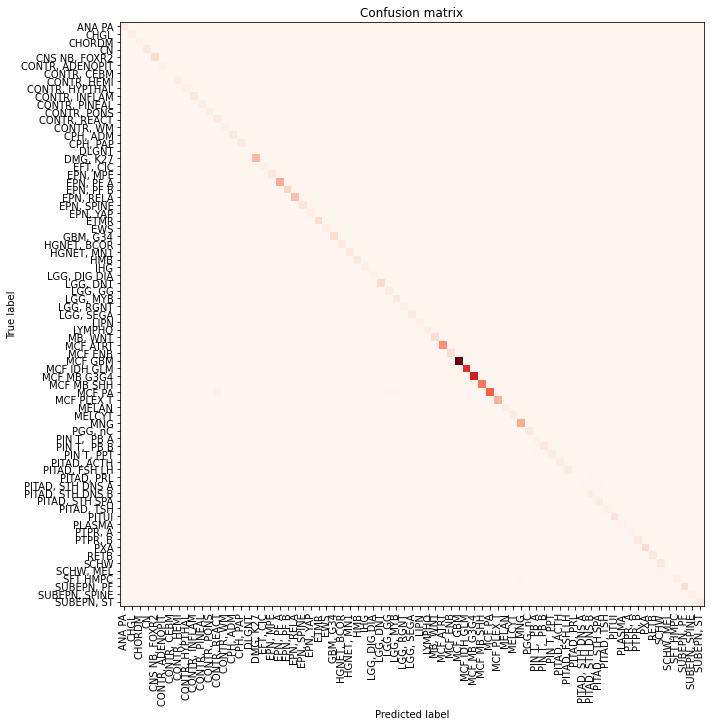

In [88]:
cmfig = plot_CM(cm, np.unique(test_y))